In [1]:
from binance.client import Client
import pandas as pd
import numpy as np

from datetime import datetime
from tqdm import tqdm
from matplotlib import pyplot as plt

params = {"font.size" : 15}
plt.rcParams.update(params)
plt.style.use('dark_background')

## Download Data

In [2]:
api_key = "Qq9dnDDRuu9BOsHixCVXq7lxw5v0Kz0bPAVbhMxob2oN49Sc3uEqW3j96krOtiKz"
api_secret = "iLFz5AZoyWyYjxnj9QXOTBQyD4AGtetkNmHvl4MYUFHGvtWBSC4KO4OaiQuZ2vsx"
client = Client(api_key, api_secret)

In [3]:
# Data Directory
data_dir = '/workspace/202205_idx-trading/_data/'
crypto_dir = '/workspace/202205_idx-trading/_data/20220624_binance-crypto-intraday/'
top100_crypto_list = '20220610_binance-top100-crypto-list.txt'
binance50_crypto_list = '20220610_binance-top50-crypto-list.txt'

# Prepare Top 100 Crypto Tickers (from CMC 20220610)
with open(data_dir + top100_crypto_list, "r") as f:
    top100_crypto_tickers = f.read().split('\n')
crypto_tickers = top100_crypto_tickers[:-1]

# Remove Some tickers (because it's very new)
rmv_tickers = ['APEBUSD', 'ICPBUSD']
crypto_tickers = [t for t in crypto_tickers if t not in rmv_tickers]

### Get List of Relevant Crypto Pairs

In [14]:
# Get Top 50 MCap, Non-Stablecoin BUSD Pair Tickers
all_tickers = [f['symbol'] for f in client.get_all_tickers()]

## Get only the first part of the BUSD pair
tickers = [f[:-4] for f in all_tickers if f[-4:] == 'BUSD']

## Get Top 100 Mcap Tickers
tickers = [f for f in tickers if f in top50_crypto_tickers]
crypto_tickers = [f+"BUSD" for f in tickers]

## Remove Stablecoins
stablecoins = ['USDCBUSD', 'USDTBUSD', 'DAIBUSD', 'USDPBUSD', 'UDSNBUSD', 'USDDBUSD']
crypto_tickers = [f for f in crypto_tickers if not(f in stablecoins)]

## Final Check
indicator = True
for ticker in crypto_tickers:
    if not(ticker in all_tickers):
        print(ticker + " does not exist")
        indicator = False
if indicator:
    print("All Pairs exist in data source")
    print("Length " + str(len(crypto_tickers)))
    
## Save to text
with open(data_dir + binance50_crypto_list, "w") as f:
    for ticker in crypto_tickers:
        f.write(ticker + "\n")
print("List of Crypto Pairs saved in: \n" + data_dir + binance50_crypto_list)

All Pairs exist in data source
Length 41
List of Crypto Pairs saved in: 
/workspace/202205_idx-trading/_data/20220610_binance-top50-crypto-list.txt


### Get Prices for Each Tickers

In [4]:
# Parameters
interval = '15m'

def epoch_to_datetime(epoch):
    return datetime.fromtimestamp(epoch/1000).strftime("%Y-%m-%dT%H:%M:%S")

# Getting data for each tickers
crypto_data = {}
for ticker in tqdm(crypto_tickers):
    try:
        raw_klines = client.get_historical_klines(ticker, interval, start_str="%2022-01-01")
    except:
        print(f'{ticker} Cannot be Downloaded')
        break
        
    raw_ohlcv = [f[:6] for f in raw_klines]
    ohlcv = {
        "Date": [epoch_to_datetime(val[0]) for val in raw_ohlcv],
        "Open": [float(val[1]) for val in raw_ohlcv], 
        "High": [float(val[2]) for val in raw_ohlcv], 
        "Low": [float(val[3]) for val in raw_ohlcv], 
        "Close": [float(val[4]) for val in raw_ohlcv], 
        "Volume": [float(val[5]) for val in raw_ohlcv], 
    }
    
    crypto_data[ticker] = pd.DataFrame(ohlcv, 
                                       columns=["Date", "Open", "High", "Low", "Close", "Volume"]).set_index('Date')

100%|███████████████████████████████████████████████████████████████████| 39/39 [05:18<00:00,  8.16s/it]


In [5]:
# Display Data
crypto_data[crypto_tickers[0]].head()

,Open,High,Low,Close,Volume
Date,,,,,
2022-01-01T00:00:00,511.6,514.0,511.5,513.6,2393.023
2022-01-01T00:15:00,513.6,514.4,513.0,514.2,791.072
2022-01-01T00:30:00,514.2,516.2,513.9,516.0,2638.118
2022-01-01T00:45:00,516.0,517.7,515.5,517.4,1415.753
2022-01-01T01:00:00,517.4,518.6,516.2,518.6,1464.739


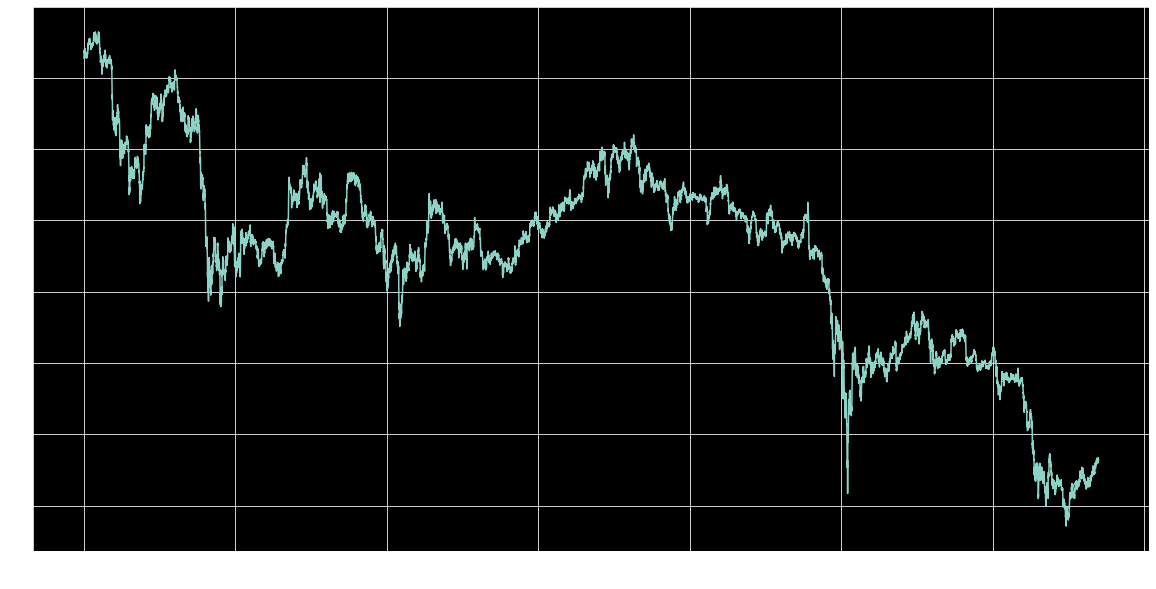

Start Date: 2022-01-01T00:00:00
Last Date : 2022-06-24T10:00:00


In [6]:
# Visualize Closing Prices
crypto_data[crypto_tickers[0]]['Close'].plot(grid=True, figsize=(20,10))
plt.show()
print('Start Date: ' + str(crypto_data[crypto_tickers[0]].index[0]))
print('Last Date : ' + str(crypto_data[crypto_tickers[0]].index[-1]))

In [7]:
# Save in csv
for ticker in tqdm(crypto_tickers):
    crypto_data[ticker].to_csv(crypto_dir + ticker + '.csv')

100%|███████████████████████████████████████████████████████████████████| 39/39 [00:16<00:00,  2.37it/s]
